In [398]:
# !pip install hurst
import seaborn as sns
import pandas as pd
# import torch.nn as nn
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader, TensorDataset
from hurst import compute_Hc
import time

In [394]:
# Functions to load a single dataset
EEG_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_eegs/'
SPEC_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_spectrograms/'
train = pd.read_csv('train.csv')


# For eeg data
def loadeeg(path):
    eeg = pd.read_parquet(path)
    return (eeg)

# For spectrograms
def loadspect(GET_ROW):
    
    row = train.iloc[GET_ROW]
#     Needs to be changed to match the eeg function
    spectrogram = pd.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
    spec_offset = int( row.spectrogram_label_offset_seconds )
    spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                         &(spectrogram.time<spec_offset+600)]
    time = (np.linspace(0,600,spectrogram.shape[0])) - 25

    
    return (row,spectrogram,time)


# Compute time domain features

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0


In [403]:
# Initialise a few things
TD_Features = {}
time_eeg = np.arange(-25, 25 + (1/200), (1/200))
start = np.argmin(np.abs(time_eeg+5))
stop = np.argmin(np.abs(time_eeg-5))

# Loop over each row of the train set
for i in range(5): #train.shape[0]:
    
    features = pd.DataFrame()
    
    # Load the data only if it is a new file
    row = train.iloc[i]
    if i == 0:
        path = f'{EEG_PATH}{row.eeg_id}.parquet'
        fulleeg = loadeeg(path)
    elif i > 0:
        prevrow = train.iloc[i-1]
        if (row.eeg_id != prevrow.eeg_id):
            path = f'{EEG_PATH}{row.eeg_id}.parquet'
            fulleeg = loadeeg(path)
            
            
    eeg_offset = int( row.eeg_label_offset_seconds )
    eeg = fulleeg.iloc[eeg_offset*200:((eeg_offset+50)*200)+1]
    
    eeg_before = eeg.iloc[:start+1]
    eeg_after  = eeg.iloc[stop:]
    eeg_during = eeg.iloc[start:stop+1]
    segments = ['before','during','after']
    
    features = row.to_frame().transpose()

    for seg in segments:
        
        if seg == 'before':
            eeg = eeg_before
        elif seg == 'during':
            eeg = eeg_during
        elif seg == 'after':
            eeg = eeg_after
        
        
        # mean
        means = eeg.mean(axis=0)
        means.index = means.index + '_mean' + seg
        means = means.to_frame().transpose()

        # SD
        sd = eeg.std(axis=0)
        sd.index = sd.index + '_sd' + seg
        sd = sd.to_frame().transpose()

        # Kurtosis
        kurt = eeg.kurt(axis=0)
        kurt.index = kurt.index + '_kurt' + seg
        kurt = kurt.to_frame().transpose()

        # Skew
        skew = eeg.skew(axis=0)
        skew.index = skew.index + '_skew' + seg
        skew = skew.to_frame().transpose()

        # Range
        rng = eeg.max() - eeg.min()
        rng.index = rng.index + '_rng' + seg
        rng = rng.to_frame().transpose()

        # RMS
        rms = (eeg**2).mean().pow(1/2)
        rms.index = rms.index + '_rms' + seg
        rms = rms.to_frame().transpose()

        # Line Length
        linelength = eeg.diff().abs().sum()
        linelength.index = linelength.index + '_linelength' + seg
        linelength = linelength.to_frame().transpose()


        # # Entropy
        # add = eeg.sum()
        # eegnorm = eeg/add
        # entropy = -(eegnorm*np.log(eegnorm)).sum() # There may be problems here with the log.
        # entropy.index = entropy.index + '_entropy' + seg
        # entropy = entropy.to_frame().transpose()


        # SVD Entropy
        eeg_z = (eeg-eeg.mean())/eeg.std()
        u, s, v = np.linalg.svd(eeg_z, full_matrices=True)
        s = s/np.sum(s)
        SVDEn = -(s*np.log(s)).sum()
        linelength['SVDEn' + seg] = SVDEn

        # Hurst Exponent
        hurst = []
        for idx,channel in enumerate(eeg.keys()):
            h, c, data = compute_Hc(eeg[channel], simplified=True)
            hurst.append(h)
        hurst = pd.DataFrame([np.array(hurst).reshape(-1)], columns=(eeg.keys()+ 'hurst' + seg))
        
        
        # Maybe also DFA

        
        # what other features do we want to add here?
        
        
        # Entropy is not added right now due to 0 problem
        features = pd.concat([features, means,sd,kurt,skew,rng,rms,linelength,hurst], axis = 1)

    TD_Features[f'{row["label_id"]}'] = features






before
during
after
before
during
after
before
during
after
before
during
after
before
during
after


In [406]:
TD_Features['3080632009']

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,Pzhurstafter,Fp2hurstafter,F4hurstafter,C4hurstafter,P4hurstafter,F8hurstafter,T4hurstafter,T6hurstafter,O2hurstafter,EKGhurstafter
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.284143,0.242965,0.229837,0.200263,0.332804,0.229006,0.196502,0.323812,0.324358,0.198816


4999


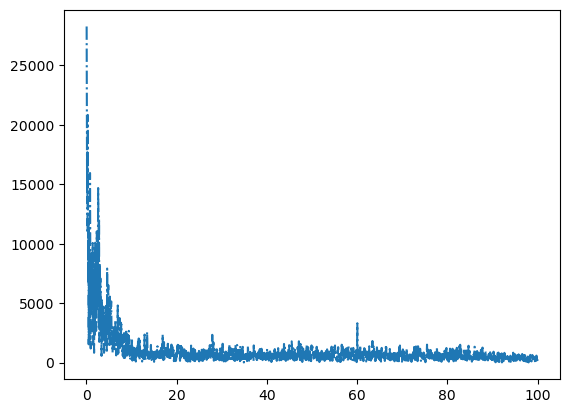

In [407]:
staticX2 = np.fft.fft(eeg['Fp1'])

staticHz = np.linspace(0,100,int(len(eeg['Fp1'])/2+1))

plt.plot(staticHz[1:],np.abs(staticX2[1:len(staticHz)]),'-.',label='FFT')
plt.show()

In [71]:
# Explore what frequencies are in the spectrogram

allkeys = spectrogram.keys()
llkeys = []
for key in allkeys:
    if 'LL' in key:
        llkeys.append(key)
        
print(llkeys)

['LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34', 'LL_2.54', 'LL_2.73', 'LL_2.93', 'LL_3.13', 'LL_3.32', 'LL_3.52', 'LL_3.71', 'LL_3.91', 'LL_4.1', 'LL_4.3', 'LL_4.49', 'LL_4.69', 'LL_4.88', 'LL_5.08', 'LL_5.27', 'LL_5.47', 'LL_5.66', 'LL_5.86', 'LL_6.05', 'LL_6.25', 'LL_6.45', 'LL_6.64', 'LL_6.84', 'LL_7.03', 'LL_7.23', 'LL_7.42', 'LL_7.62', 'LL_7.81', 'LL_8.01', 'LL_8.2', 'LL_8.4', 'LL_8.59', 'LL_8.79', 'LL_8.98', 'LL_9.18', 'LL_9.38', 'LL_9.57', 'LL_9.77', 'LL_9.96', 'LL_10.16', 'LL_10.35', 'LL_10.55', 'LL_10.74', 'LL_10.94', 'LL_11.13', 'LL_11.33', 'LL_11.52', 'LL_11.72', 'LL_11.91', 'LL_12.11', 'LL_12.3', 'LL_12.5', 'LL_12.7', 'LL_12.89', 'LL_13.09', 'LL_13.28', 'LL_13.48', 'LL_13.67', 'LL_13.87', 'LL_14.06', 'LL_14.26', 'LL_14.45', 'LL_14.65', 'LL_14.84', 'LL_15.04', 'LL_15.23', 'LL_15.43', 'LL_15.63', 'LL_15.82', 'LL_16.02', 'LL_16.21', 'LL_16.41', 'LL_16.6', 'LL_16.8', 'LL_16.99', 'LL_17.19', 'LL_17.38', 'LL_17.58', '

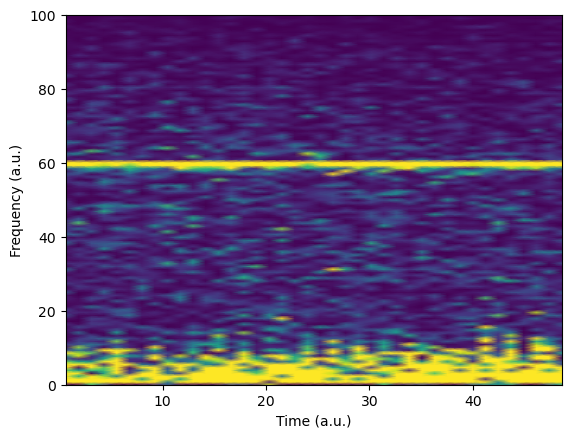

In [88]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(eeg['Fp1'].to_numpy(),fs = 200,noverlap=10)
plt.pcolormesh(t,f,Sxx,shading='gouraud',vmin=0,vmax=10)
plt.ylabel('Frequency (a.u.)')
plt.xlabel('Time (a.u.)')
# plt.ylim([0,.005])
plt.show()


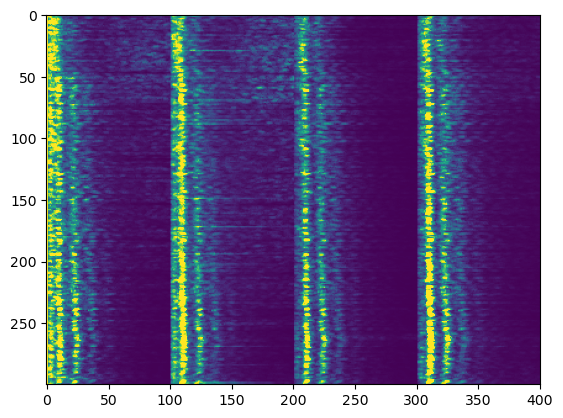

In [42]:
spect = spectrogram.to_numpy()
plt.imshow(spect,vmin= 0, vmax = 10)
plt.show()

In [408]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(fulleeg)

# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

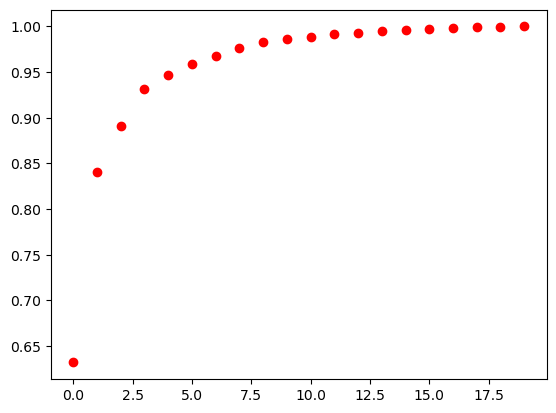

[0.6321207  0.84039474 0.89101166 0.93116635 0.94682753 0.9590187
 0.96814543 0.97680265 0.9825641  0.9858906  0.9889444  0.99122006
 0.99325097 0.9949197  0.9963606  0.9974092  0.9983734  0.999024
 0.9996212  1.0000001 ]


In [414]:

plt.plot(np.cumsum(pca.explained_variance_ratio_),'ro')
plt.show()
print(np.cumsum(pca.explained_variance_ratio_))